### Import json and pandas

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType, BooleanType, DateType, DoubleType 
from pyspark.sql.functions import explode
from pyspark.sql import Row

# 1.0 Flattening and Exploratory Data Analysis

### Pipeline

At this point, the data is being published to the streaming context portion of the pipeline.  The messages are read through the queue.  Kafka topic is assessments with one partition and a replication factor of one.  Some of the events that take place in the streaming context are decoration and notifications.

### Creating a Kafka source for streaming queries. Read messages from Kafka topic assessments. 
Setting the port of the Kafka container.  
Subscribe to topic assessments.  Reading from one topic.
Offset starts at the beginning.  
Read until the end of the file.  
Load the data in raw assessments.

In [5]:
raw_assessments = spark \
  .read \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "kafka:29092") \
  .option("subscribe","assessments") \
  .option("startingOffsets", "earliest") \
  .option("endingOffsets", "latest") \
  .load()

raw_assessments is a pyspark.sql.dataframe

In [6]:
type(raw_assessments)

pyspark.sql.dataframe.DataFrame

Load raw_assessments into cache.

In [7]:
raw_assessments.cache()

DataFrame[key: binary, value: binary, topic: string, partition: int, offset: bigint, timestamp: timestamp, timestampType: int]

## 1.1 Initial Schema

After initially importing the assessment json file, it is noticed that the column 'value' is of type binary.  The binary format is then converted to type string.  Thorough exploratory data analysis of the first assessment ensues.  The analysis reveals that much of the pertinent data needed to obtain insights are nested inside the sequences object.  At this point, it is evident that the file is nested quite extensively.  Custom functions were used to extract some of the data.  Although the outcome was successful, the means to the end were complex.  A third party data scientist could be reluctant to attempt further analysis.   In order to prepare the file for third-party data scientists, other attempts will be made to more easily access the data inside counts and sequences.  The data contained within counts and questions are essential for gaining valuable assessment insights.

### Print schema

In [8]:
raw_assessments.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



### Show messages

In [9]:
raw_assessments.show()

+----+--------------------+-----------+---------+------+--------------------+-------------+
| key|               value|      topic|partition|offset|           timestamp|timestampType|
+----+--------------------+-----------+---------+------+--------------------+-------------+
|null|[7B 22 6B 65 65 6...|assessments|        0|     0|1969-12-31 23:59:...|            0|
|null|[7B 22 6B 65 65 6...|assessments|        0|     1|1969-12-31 23:59:...|            0|
|null|[7B 22 6B 65 65 6...|assessments|        0|     2|1969-12-31 23:59:...|            0|
|null|[7B 22 6B 65 65 6...|assessments|        0|     3|1969-12-31 23:59:...|            0|
|null|[7B 22 6B 65 65 6...|assessments|        0|     4|1969-12-31 23:59:...|            0|
|null|[7B 22 6B 65 65 6...|assessments|        0|     5|1969-12-31 23:59:...|            0|
|null|[7B 22 6B 65 65 6...|assessments|        0|     6|1969-12-31 23:59:...|            0|
|null|[7B 22 6B 65 65 6...|assessments|        0|     7|1969-12-31 23:59:...|   

### Cast column value as strings

In [10]:
s_assessments=raw_assessments.select(raw_assessments.value.cast('string'))

### Show s_assessments

In [11]:
s_assessments.show(10)

+--------------------+
|               value|
+--------------------+
|{"keen_timestamp"...|
|{"keen_timestamp"...|
|{"keen_timestamp"...|
|{"keen_timestamp"...|
|{"keen_timestamp"...|
|{"keen_timestamp"...|
|{"keen_timestamp"...|
|{"keen_timestamp"...|
|{"keen_timestamp"...|
|{"keen_timestamp"...|
+--------------------+
only showing top 10 rows



### Count the number of assessments

In [12]:
s_assessments.count()

6560

### Select the first assessment and look at it.

In [13]:
first_assessment=s_assessments.select('value').take(1)
first_assessment

[Row(value='{"keen_timestamp":"1516717442.735266","max_attempts":"1.0","started_at":"2018-01-23T14:23:19.082Z","base_exam_id":"37f0a30a-7464-11e6-aa92-a8667f27e5dc","user_exam_id":"6d4089e4-bde5-4a22-b65f-18bce9ab79c8","sequences":{"questions":[{"user_incomplete":true,"user_correct":false,"options":[{"checked":true,"at":"2018-01-23T14:23:24.670Z","id":"49c574b4-5c82-4ffd-9bd1-c3358faf850d","submitted":1,"correct":true},{"checked":true,"at":"2018-01-23T14:23:25.914Z","id":"f2528210-35c3-4320-acf3-9056567ea19f","submitted":1,"correct":true},{"checked":false,"correct":true,"id":"d1bf026f-554f-4543-bdd2-54dcf105b826"}],"user_submitted":true,"id":"7a2ed6d3-f492-49b3-b8aa-d080a8aad986","user_result":"missed_some"},{"user_incomplete":false,"user_correct":false,"options":[{"checked":true,"at":"2018-01-23T14:23:30.116Z","id":"a35d0e80-8c49-415d-b8cb-c21a02627e2b","submitted":1},{"checked":false,"correct":true,"id":"bccd6e2e-2cef-4c72-8bfa-317db0ac48bb"},{"checked":true,"at":"2018-01-23T14:23:41

### First assessment is type list.  We must extract the first object.

In [14]:
first_assessment=json.loads(s_assessments.select('value').take(1)[0].value)
first_assessment

{'base_exam_id': '37f0a30a-7464-11e6-aa92-a8667f27e5dc',
 'certification': 'false',
 'exam_name': 'Normal Forms and All That Jazz Master Class',
 'keen_created_at': '1516717442.735266',
 'keen_id': '5a6745820eb8ab00016be1f1',
 'keen_timestamp': '1516717442.735266',
 'max_attempts': '1.0',
 'sequences': {'attempt': 1,
  'counts': {'all_correct': False,
   'correct': 2,
   'incomplete': 1,
   'incorrect': 1,
   'submitted': 4,
   'total': 4,
   'unanswered': 0},
  'id': '5b28a462-7a3b-42e0-b508-09f3906d1703',
  'questions': [{'id': '7a2ed6d3-f492-49b3-b8aa-d080a8aad986',
    'options': [{'at': '2018-01-23T14:23:24.670Z',
      'checked': True,
      'correct': True,
      'id': '49c574b4-5c82-4ffd-9bd1-c3358faf850d',
      'submitted': 1},
     {'at': '2018-01-23T14:23:25.914Z',
      'checked': True,
      'correct': True,
      'id': 'f2528210-35c3-4320-acf3-9056567ea19f',
      'submitted': 1},
     {'checked': False,
      'correct': True,
      'id': 'd1bf026f-554f-4543-bdd2-54dcf10

### First assessment object type is now a dict

In [15]:
type(first_assessment)

dict

### First assessment keys

In [16]:
print(*first_assessment.keys() , sep='\n')

keen_timestamp
max_attempts
started_at
base_exam_id
user_exam_id
sequences
keen_created_at
certification
keen_id
exam_name


### First assessment values

In [17]:
print(*first_assessment.values() , sep='\n')

1516717442.735266
1.0
2018-01-23T14:23:19.082Z
37f0a30a-7464-11e6-aa92-a8667f27e5dc
6d4089e4-bde5-4a22-b65f-18bce9ab79c8
{'questions': [{'user_incomplete': True, 'user_correct': False, 'options': [{'checked': True, 'at': '2018-01-23T14:23:24.670Z', 'id': '49c574b4-5c82-4ffd-9bd1-c3358faf850d', 'submitted': 1, 'correct': True}, {'checked': True, 'at': '2018-01-23T14:23:25.914Z', 'id': 'f2528210-35c3-4320-acf3-9056567ea19f', 'submitted': 1, 'correct': True}, {'checked': False, 'correct': True, 'id': 'd1bf026f-554f-4543-bdd2-54dcf105b826'}], 'user_submitted': True, 'id': '7a2ed6d3-f492-49b3-b8aa-d080a8aad986', 'user_result': 'missed_some'}, {'user_incomplete': False, 'user_correct': False, 'options': [{'checked': True, 'at': '2018-01-23T14:23:30.116Z', 'id': 'a35d0e80-8c49-415d-b8cb-c21a02627e2b', 'submitted': 1}, {'checked': False, 'correct': True, 'id': 'bccd6e2e-2cef-4c72-8bfa-317db0ac48bb'}, {'checked': True, 'at': '2018-01-23T14:23:41.791Z', 'id': '7e0b639a-2ef8-4604-b7eb-5018bd81a91

### Access different values of first assessment

In [18]:
print(first_assessment['keen_timestamp'])

1516717442.735266


In [19]:
print(*first_assessment['max_attempts'])

1 . 0


In [20]:
print(first_assessment['started_at'])

2018-01-23T14:23:19.082Z


In [21]:
first_assessment['exam_name']

'Normal Forms and All That Jazz Master Class'

In [22]:
print(*first_assessment['sequences'].keys(), sep="\n")

questions
attempt
id
counts


In [23]:
print(*first_assessment['sequences'].values(), sep="\n")

[{'user_incomplete': True, 'user_correct': False, 'options': [{'checked': True, 'at': '2018-01-23T14:23:24.670Z', 'id': '49c574b4-5c82-4ffd-9bd1-c3358faf850d', 'submitted': 1, 'correct': True}, {'checked': True, 'at': '2018-01-23T14:23:25.914Z', 'id': 'f2528210-35c3-4320-acf3-9056567ea19f', 'submitted': 1, 'correct': True}, {'checked': False, 'correct': True, 'id': 'd1bf026f-554f-4543-bdd2-54dcf105b826'}], 'user_submitted': True, 'id': '7a2ed6d3-f492-49b3-b8aa-d080a8aad986', 'user_result': 'missed_some'}, {'user_incomplete': False, 'user_correct': False, 'options': [{'checked': True, 'at': '2018-01-23T14:23:30.116Z', 'id': 'a35d0e80-8c49-415d-b8cb-c21a02627e2b', 'submitted': 1}, {'checked': False, 'correct': True, 'id': 'bccd6e2e-2cef-4c72-8bfa-317db0ac48bb'}, {'checked': True, 'at': '2018-01-23T14:23:41.791Z', 'id': '7e0b639a-2ef8-4604-b7eb-5018bd81a91b', 'submitted': 1, 'correct': True}], 'user_submitted': True, 'id': 'bbed4358-999d-4462-9596-bad5173a6ecb', 'user_result': 'incorrect'

### The object questions is a list

In [24]:
type(first_assessment['sequences']['questions'])

list

### A look at first assessment sequences-questions

In [25]:
first_assessment['sequences']['questions']

[{'id': '7a2ed6d3-f492-49b3-b8aa-d080a8aad986',
  'options': [{'at': '2018-01-23T14:23:24.670Z',
    'checked': True,
    'correct': True,
    'id': '49c574b4-5c82-4ffd-9bd1-c3358faf850d',
    'submitted': 1},
   {'at': '2018-01-23T14:23:25.914Z',
    'checked': True,
    'correct': True,
    'id': 'f2528210-35c3-4320-acf3-9056567ea19f',
    'submitted': 1},
   {'checked': False,
    'correct': True,
    'id': 'd1bf026f-554f-4543-bdd2-54dcf105b826'}],
  'user_correct': False,
  'user_incomplete': True,
  'user_result': 'missed_some',
  'user_submitted': True},
 {'id': 'bbed4358-999d-4462-9596-bad5173a6ecb',
  'options': [{'at': '2018-01-23T14:23:30.116Z',
    'checked': True,
    'id': 'a35d0e80-8c49-415d-b8cb-c21a02627e2b',
    'submitted': 1},
   {'checked': False,
    'correct': True,
    'id': 'bccd6e2e-2cef-4c72-8bfa-317db0ac48bb'},
   {'at': '2018-01-23T14:23:41.791Z',
    'checked': True,
    'correct': True,
    'id': '7e0b639a-2ef8-4604-b7eb-5018bd81a91b',
    'submitted': 1}]

### A look at first assessment sequences-questions[0]

In [26]:
first_assessment['sequences']['questions'][0]

{'id': '7a2ed6d3-f492-49b3-b8aa-d080a8aad986',
 'options': [{'at': '2018-01-23T14:23:24.670Z',
   'checked': True,
   'correct': True,
   'id': '49c574b4-5c82-4ffd-9bd1-c3358faf850d',
   'submitted': 1},
  {'at': '2018-01-23T14:23:25.914Z',
   'checked': True,
   'correct': True,
   'id': 'f2528210-35c3-4320-acf3-9056567ea19f',
   'submitted': 1},
  {'checked': False,
   'correct': True,
   'id': 'd1bf026f-554f-4543-bdd2-54dcf105b826'}],
 'user_correct': False,
 'user_incomplete': True,
 'user_result': 'missed_some',
 'user_submitted': True}

### Get first assessment value in sequences.questions[0].options[0].id

This is not a good method of extracting data

In [27]:
first_assessment['sequences']['questions'][0]['options'][0]['id']

'49c574b4-5c82-4ffd-9bd1-c3358faf850d'

### A look at first assessment sequences-counts

In [28]:
first_assessment['sequences']['counts']

{'all_correct': False,
 'correct': 2,
 'incomplete': 1,
 'incorrect': 1,
 'submitted': 4,
 'total': 4,
 'unanswered': 0}

In [29]:
first_assessment['sequences']['counts'].keys()

dict_keys(['incomplete', 'submitted', 'incorrect', 'all_correct', 'correct', 'total', 'unanswered'])

In [30]:
first_assessment['sequences']['counts'].values()

dict_values([1, 4, 1, False, 2, 4, 0])

### First attempt to find how many people took Learning Git.

This code takes too long to return the exam names

In [31]:
l_exam_name = []
num = 0

for i in range(1,5):
    assessment=json.loads(s_assessments.select('value').take(i)[i-1].value)
    if assessment['exam_name'] == 'Learning Git':
        num+=1

print(num)

0


### Writing a function ultimately returns the total number of assessments, though it is rather cumbersome.

In [32]:
def get_exam_name(x):
    raw_dict = json.loads(x.value)
    exam_dict = {"keen_id" : raw_dict["keen_id"], 
               "exam_name" : raw_dict["exam_name"]}
    return exam_dict
get_exam_name = s_assessments.rdd.map(get_exam_name).toDF()
get_exam_name.show(5)
get_exam_name
get_exam_name.registerTempTable("exam_name")

/spark-2.2.0-bin-hadoop2.6/python/pyspark/sql/session.py:351: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


+--------------------+--------------------+
|           exam_name|             keen_id|
+--------------------+--------------------+
|Normal Forms and ...|5a6745820eb8ab000...|
|Normal Forms and ...|5a674541ab6b0a000...|
|The Principles of...|5a67999d3ed3e3000...|
|The Principles of...|5a6799694fc7c7000...|
|Introduction to B...|5a6791e824fccd000...|
+--------------------+--------------------+
only showing top 5 rows



In [33]:
learning_git = spark.sql("select exam_name from exam_name where exam_name = 'Learning Git'")
learning_git.show(5)

+------------+
|   exam_name|
+------------+
|Learning Git|
|Learning Git|
|Learning Git|
|Learning Git|
|Learning Git|
+------------+
only showing top 5 rows



In [34]:
spark.sql("select count(exam_name) from exam_name where exam_name = 'Learning Git'").show()

+----------------+
|count(exam_name)|
+----------------+
|             788|
+----------------+



### Function get_counts_01 to access sequences.counts data

In [35]:
def get_counts_01(x):
    raw_dict = json.loads(x.value)
    counts_dict = {"exam_name" : raw_dict["exam_name"],
               "total" : raw_dict["sequences"]["counts"]["total"],
               "correct" : raw_dict["sequences"]["counts"]["correct"],
               "all_correct" : raw_dict["sequences"]["counts"]["all_correct"]}
    return counts_dict
get_counts_01 = s_assessments.rdd.map(get_counts_01).toDF()
get_counts_01.show(5)
get_counts_01.registerTempTable('counts_01')

/spark-2.2.0-bin-hadoop2.6/python/pyspark/sql/session.py:351: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


+-----------+-------+--------------------+-----+
|all_correct|correct|           exam_name|total|
+-----------+-------+--------------------+-----+
|      false|      2|Normal Forms and ...|    4|
|      false|      1|Normal Forms and ...|    4|
|      false|      3|The Principles of...|    4|
|      false|      2|The Principles of...|    4|
|      false|      3|Introduction to B...|    4|
+-----------+-------+--------------------+-----+
only showing top 5 rows



In [36]:
spark.sql("select exam_name, total, correct from counts_01").show(5)

+--------------------+-----+-------+
|           exam_name|total|correct|
+--------------------+-----+-------+
|Normal Forms and ...|    4|      2|
|Normal Forms and ...|    4|      1|
|The Principles of...|    4|      3|
|The Principles of...|    4|      2|
|Introduction to B...|    4|      3|
+--------------------+-----+-------+
only showing top 5 rows



### Running this SQL query throws an error

In [37]:
# spark.sql("select exam_name, sum(total) total_num_questions, sum(correct) total_questions_correct \
            # from counts_01 group by exam_name").show()

### Function get_counts_02 to access data in sequences.counts.  Second iteration accounts for missing keys in original assessments json file.

In [38]:
def get_counts_02(x):
    
    raw_dict = json.loads(x.value)
    my_list = []
    
    if "sequences" in raw_dict:
        if "counts" in raw_dict["sequences"]:
            if "correct" in raw_dict["sequences"]["counts"] and "total" in raw_dict["sequences"]["counts"]: 
                my_dict = {"exam_name" : raw_dict["exam_name"],
                           "correct": raw_dict["sequences"]["counts"]["correct"], 
                           "total": raw_dict["sequences"]["counts"]["total"]}
                my_list.append(Row(**my_dict))
    return my_list

df_correct_total = s_assessments.rdd.flatMap(get_counts_02).toDF()
df_correct_total.registerTempTable('counts_02')
spark.sql("select * from counts_02 limit 10").show()

+-------+--------------------+-----+
|correct|           exam_name|total|
+-------+--------------------+-----+
|      2|Normal Forms and ...|    4|
|      1|Normal Forms and ...|    4|
|      3|The Principles of...|    4|
|      2|The Principles of...|    4|
|      3|Introduction to B...|    4|
|      5|        Learning Git|    5|
|      1|Git Fundamentals ...|    1|
|      5|Introduction to P...|    5|
|      4|Intermediate Pyth...|    4|
|      0|Introduction to P...|    5|
+-------+--------------------+-----+



### This query is the same as above but it works.

In [39]:
spark.sql("select exam_name, sum(total) total_num_questions, sum(correct) total_questions_correct \
            from counts_02 group by exam_name").show()

+--------------------+-------------------+-----------------------+
|           exam_name|total_num_questions|total_questions_correct|
+--------------------+-------------------+-----------------------+
|Learning Data Mod...|                 72|                     36|
|Networking for Pe...|                 90|                     50|
|Introduction to J...|               1580|                   1384|
|Learning Apache H...|                128|                     98|
|Learning Spring P...|                 16|                     10|
|Learning iPython ...|                136|                     68|
|Introduction to P...|               1620|                    918|
|Learning C# Best ...|                350|                    162|
|Introduction to A...|                 84|                     46|
|A Practical Intro...|                 72|                     42|
|I'm a Software Ar...|                120|                     64|
|Introduction to B...|                600|                    

## 1.2 First Schema


This schema applies a rdd.map lambda function to flatten the assessments json file.  The lambda function converts the data passed into it to its datatype. Next, the spark.sql row function is used to avoid deprecation and work a row at a time.  Then, applying a map works an element at a time. The rdd.map lambda function is taking a dataframe and mapping it to a Spark dataframe.  RDD is Spark's distributed dataset.  This schema contains some flat data; base_exam_id, certification, exam_name, etc. that are queried at this point.  Furthermore, SQL queries can be run on the sequences.quesitons data.  However, sequences.counts data is still returning null errors. This is likely due to missing keys in the dictionary of the original file.  Counts data can be accessed as done previously using custom lambda functions, which return a list that is passed into an rdd.flatMap function.  Nevertheless, there might be a different way.

### Extract assessments using rdd.map lambda function

In [40]:
extracted_assessments_first_schema = s_assessments.rdd.map(lambda x: Row(**json.loads(x.value))).toDF()

### Visualize schema

In [41]:
extracted_assessments_first_schema.printSchema()

root
 |-- base_exam_id: string (nullable = true)
 |-- certification: string (nullable = true)
 |-- exam_name: string (nullable = true)
 |-- keen_created_at: string (nullable = true)
 |-- keen_id: string (nullable = true)
 |-- keen_timestamp: string (nullable = true)
 |-- max_attempts: string (nullable = true)
 |-- sequences: map (nullable = true)
 |    |-- key: string
 |    |-- value: array (valueContainsNull = true)
 |    |    |-- element: map (containsNull = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: boolean (valueContainsNull = true)
 |-- started_at: string (nullable = true)
 |-- user_exam_id: string (nullable = true)



In [42]:
extracted_assessments_first_schema.show(1)

+--------------------+-------------+--------------------+-----------------+--------------------+-----------------+------------+--------------------+--------------------+--------------------+
|        base_exam_id|certification|           exam_name|  keen_created_at|             keen_id|   keen_timestamp|max_attempts|           sequences|          started_at|        user_exam_id|
+--------------------+-------------+--------------------+-----------------+--------------------+-----------------+------------+--------------------+--------------------+--------------------+
|37f0a30a-7464-11e...|        false|Normal Forms and ...|1516717442.735266|5a6745820eb8ab000...|1516717442.735266|         1.0|Map(questions -> ...|2018-01-23T14:23:...|6d4089e4-bde5-4a2...|
+--------------------+-------------+--------------------+-----------------+--------------------+-----------------+------------+--------------------+--------------------+--------------------+
only showing top 1 row



### Analyze first assessment

In [43]:
first_assessment_02 = extracted_assessments_first_schema.take(1)[0]
first_assessment_02
#first_assessment=json.loads(s_assessments.select('value').take(1)[0].value)

Row(base_exam_id='37f0a30a-7464-11e6-aa92-a8667f27e5dc', certification='false', exam_name='Normal Forms and All That Jazz Master Class', keen_created_at='1516717442.735266', keen_id='5a6745820eb8ab00016be1f1', keen_timestamp='1516717442.735266', max_attempts='1.0', sequences={'questions': [{'options': None, 'user_correct': False, 'user_incomplete': True, 'id': None, 'user_result': None, 'user_submitted': True}, {'options': None, 'user_correct': False, 'user_incomplete': False, 'id': None, 'user_result': None, 'user_submitted': True}, {'options': None, 'user_correct': True, 'user_incomplete': False, 'id': None, 'user_result': None, 'user_submitted': True}, {'options': None, 'user_correct': True, 'user_incomplete': False, 'id': None, 'user_result': None, 'user_submitted': True}], 'id': None, 'attempt': None, 'counts': None}, started_at='2018-01-23T14:23:19.082Z', user_exam_id='6d4089e4-bde5-4a22-b65f-18bce9ab79c8')

### Create SQL view assessments_first_format

In [44]:
extracted_assessments_first_schema.registerTempTable('assessments_first_format')

### Querying exam_name works

In [45]:
spark.sql("select distinct(exam_name) from assessments_first_format").show(5)

+--------------------+
|           exam_name|
+--------------------+
|Learning Data Mod...|
|Networking for Pe...|
|Introduction to J...|
|Learning Apache H...|
|Learning Spring P...|
+--------------------+
only showing top 5 rows



### Sequences.counts gives an error

In [46]:
#spark.sql("select sequences.counts.total total from assessments_first_format").show(5)

### Sequences.questions is working

In [47]:
spark.sql("select sequences.questions[0].user_incomplete user from assessments_first_format").show(5)

+-----+
| user|
+-----+
| true|
|false|
|false|
|false|
|false|
+-----+
only showing top 5 rows



In [48]:
spark.sql("select sequences.questions[0].user_correct user from assessments_first_format").show(5)

+-----+
| user|
+-----+
|false|
| true|
|false|
| true|
|false|
+-----+
only showing top 5 rows



## 1.3 Second Schema

The second attempt at flattening the assessments json file uses an enforced schema named second_schema.  The second_schema is placed in the toDF command to create the specified class.  SQL function StructType allows the user to specify a list or tuple.  The StructType list is used in the schema along with StructField.  StructField has the following options: name, datatype, and [nullable].  Name is used to build the schema using the same key names as the original file.  The datatype is specified according to the expected value.  Nullable is true by default.  The enforced schema works well to flatten the nested counts data.  Unfortunately, this method ignores the data in sequences.questions.

### Build the enforced schema
Located at the very bottom of Spark 2.3.0 Spark SQL, DataFrames and Dataset Guide

In [49]:
second_schema = StructType([
                StructField('keen_timestamp', StringType()),
                StructField('max_attempts', StringType()),
                StructField('started_at', StringType()),
                StructField('base_exam_id', StringType()),
                StructField('user_exam_id', StringType()),
                StructField('sequences', StructType([
                    StructField('attempt', IntegerType()),
                    StructField('id', StringType()),
                    StructField('counts', StructType([
                        StructField('incomplete', IntegerType()),
                        StructField('submitted', IntegerType()),
                        StructField('incorrect', IntegerType()),
                        StructField('all_correct', BooleanType()),
                        StructField('correct', IntegerType()),
                        StructField('total', IntegerType()),
                        StructField('unanswered', IntegerType())
                                                    ]))
                                                ])),
                StructField('keen_created_at', StringType()),
                StructField('certification', StringType()),
                StructField('keen_id', StringType()),
                StructField('exam_name', StringType())
                                                    ])


### Extract the assessments using the manually built schema

In [50]:
extracted_assessments_second_schema = s_assessments.rdd.map(lambda x: json.loads(x.value)).toDF(schema=second_schema)

### Visualize the schema

In [51]:
extracted_assessments_second_schema.printSchema()

root
 |-- keen_timestamp: string (nullable = true)
 |-- max_attempts: string (nullable = true)
 |-- started_at: string (nullable = true)
 |-- base_exam_id: string (nullable = true)
 |-- user_exam_id: string (nullable = true)
 |-- sequences: struct (nullable = true)
 |    |-- attempt: integer (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- counts: struct (nullable = true)
 |    |    |-- incomplete: integer (nullable = true)
 |    |    |-- submitted: integer (nullable = true)
 |    |    |-- incorrect: integer (nullable = true)
 |    |    |-- all_correct: boolean (nullable = true)
 |    |    |-- correct: integer (nullable = true)
 |    |    |-- total: integer (nullable = true)
 |    |    |-- unanswered: integer (nullable = true)
 |-- keen_created_at: string (nullable = true)
 |-- certification: string (nullable = true)
 |-- keen_id: string (nullable = true)
 |-- exam_name: string (nullable = true)



In [52]:
extracted_assessments_second_schema.show(1)

+-----------------+------------+--------------------+--------------------+--------------------+--------------------+-----------------+-------------+--------------------+--------------------+
|   keen_timestamp|max_attempts|          started_at|        base_exam_id|        user_exam_id|           sequences|  keen_created_at|certification|             keen_id|           exam_name|
+-----------------+------------+--------------------+--------------------+--------------------+--------------------+-----------------+-------------+--------------------+--------------------+
|1516717442.735266|         1.0|2018-01-23T14:23:...|37f0a30a-7464-11e...|6d4089e4-bde5-4a2...|[1,5b28a462-7a3b-...|1516717442.735266|        false|5a6745820eb8ab000...|Normal Forms and ...|
+-----------------+------------+--------------------+--------------------+--------------------+--------------------+-----------------+-------------+--------------------+--------------------+
only showing top 1 row



### View the first assessment

In [53]:
first_assessment_03 = extracted_assessments_second_schema.take(1)[0]
first_assessment_03

Row(keen_timestamp='1516717442.735266', max_attempts='1.0', started_at='2018-01-23T14:23:19.082Z', base_exam_id='37f0a30a-7464-11e6-aa92-a8667f27e5dc', user_exam_id='6d4089e4-bde5-4a22-b65f-18bce9ab79c8', sequences=Row(attempt=1, id='5b28a462-7a3b-42e0-b508-09f3906d1703', counts=Row(incomplete=1, submitted=4, incorrect=1, all_correct=False, correct=2, total=4, unanswered=0)), keen_created_at='1516717442.735266', certification='false', keen_id='5a6745820eb8ab00016be1f1', exam_name='Normal Forms and All That Jazz Master Class')

### Create SQL view assessement_second_format

In [54]:
extracted_assessments_second_schema.registerTempTable('assessments_second_format')

### Querying exam_name works

In [55]:
spark.sql("select distinct(exam_name) from assessments_second_format").show(5)

+--------------------+
|           exam_name|
+--------------------+
|Learning Data Mod...|
|Networking for Pe...|
|Introduction to J...|
|Learning Apache H...|
|Learning Spring P...|
+--------------------+
only showing top 5 rows



### Querying sequences.counts.incomplete works

In [56]:
spark.sql("select sequences.counts.incomplete from assessments_second_format").show(5)

+----------+
|incomplete|
+----------+
|         1|
|         2|
|         0|
|         2|
|         0|
+----------+
only showing top 5 rows



### Sequences.quesitions was unfortunately not addressed in this schema

## 1.4 Final Schema

The final schema allows third party data scientists to access all the data in the original assessments json file.  First a rdd.map and lambda function are applied to map every value in s_assessment to its datatype.  Next, the spark.read.json command automatically infers the schema of the newly created JSON data set assessments and returns each object as dataframe.  The conversion is possible because each line contains a separate, self-contained valid JSON object.  Thus far, there have been several contrived methods of querying the data in sequences.questions and sequences.counts.  Furthermore, the final_schema is used throughout the remainder of the analysis due to its ease of use.

### Apply value map to each RDD element

In [57]:
assessments = s_assessments.rdd.map(lambda x: x.value)

### Read/load json file return the result of assessements as a dataframe

Good reference in pyspark documentation 3.0.0

In [58]:
extracted_assessments = spark.read.json(assessments)

### Visualize inferred schema

In [59]:
extracted_assessments.printSchema()

root
 |-- base_exam_id: string (nullable = true)
 |-- certification: string (nullable = true)
 |-- exam_name: string (nullable = true)
 |-- keen_created_at: string (nullable = true)
 |-- keen_id: string (nullable = true)
 |-- keen_timestamp: string (nullable = true)
 |-- max_attempts: string (nullable = true)
 |-- sequences: struct (nullable = true)
 |    |-- attempt: long (nullable = true)
 |    |-- counts: struct (nullable = true)
 |    |    |-- all_correct: boolean (nullable = true)
 |    |    |-- correct: long (nullable = true)
 |    |    |-- incomplete: long (nullable = true)
 |    |    |-- incorrect: long (nullable = true)
 |    |    |-- submitted: long (nullable = true)
 |    |    |-- total: long (nullable = true)
 |    |    |-- unanswered: long (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- questions: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- id: string (nullable = true)
 |    |    |    |-- options: arra

### Remove duplicate keen_ids/exams from the dataset

In [60]:
extracted_assessments = extracted_assessments.dropDuplicates(['keen_id'])

### Save to cache

In [61]:
extracted_assessments.cache()

DataFrame[base_exam_id: string, certification: string, exam_name: string, keen_created_at: string, keen_id: string, keen_timestamp: string, max_attempts: string, sequences: struct<attempt:bigint,counts:struct<all_correct:boolean,correct:bigint,incomplete:bigint,incorrect:bigint,submitted:bigint,total:bigint,unanswered:bigint>,id:string,questions:array<struct<id:string,options:array<struct<at:string,checked:boolean,correct:boolean,id:string,submitted:bigint>>,user_correct:boolean,user_incomplete:boolean,user_result:string,user_submitted:boolean>>>, started_at: string, user_exam_id: string]

In [62]:
extracted_assessments.show(1)

+--------------------+-------------+--------------------+------------------+--------------------+------------------+------------+--------------------+--------------------+--------------------+
|        base_exam_id|certification|           exam_name|   keen_created_at|             keen_id|    keen_timestamp|max_attempts|           sequences|          started_at|        user_exam_id|
+--------------------+-------------+--------------------+------------------+--------------------+------------------+------------+--------------------+--------------------+--------------------+
|1a233da8-e6e5-48a...|        false|Intermediate Pyth...|1511499390.3836269|5a17a67efa1257000...|1511499390.3836269|         1.0|[1,[false,1,0,3,4...|2017-11-24T04:54:...|ab96c540-1dbb-4c3...|
+--------------------+-------------+--------------------+------------------+--------------------+------------------+------------+--------------------+--------------------+--------------------+
only showing top 1 row



# 2.0 SQL view assessments is created

### Pipeline

The registerTempTable() command registers a dataframe as a temporary table in the SQL context.  The data is stored using Hive's highly-optimized, in-memory columnar format.

In [63]:
extracted_assessments.registerTempTable('assessments')

### Can access the list of sequences.questions.user_correct for the first assessment

In [64]:
spark.sql("select sequences.questions.user_correct user_correct from assessments").show(1)

+--------------------+
|        user_correct|
+--------------------+
|[false, false, fa...|
+--------------------+
only showing top 1 row



### Can access the first element in the list of sequences.questions.user_correct of the first assessment

In [65]:
spark.sql("select sequences.questions.user_correct[0] user_correct from assessments").show(1)

+------------+
|user_correct|
+------------+
|       false|
+------------+
only showing top 1 row



### Can access the first element in sequences.counts.total of the first assessment

In [66]:
spark.sql("select sequences.counts.total total_questions from assessments").show(1)

+---------------+
|total_questions|
+---------------+
|              4|
+---------------+
only showing top 1 row



# 3.0 Questions

### Pipeline

A query tool is located at the end of the pipeline.  Keep in mind that the queries are run from a temporary table that was stored in Hive.

### 3.1 How many assessments are in the dataset?
There are 3,242 assessments in the dataset.

In [67]:
spark.sql("select count(exam_name) total_assessments from assessments").show()

+-----------------+
|total_assessments|
+-----------------+
|             3242|
+-----------------+



### 3.2 What's the name of your Kafka topic? How did you come up with that name?

The name of my Kafka topic is assessments.  I used the name assessments because the topic is subscribed to assessment data from the assessment json file.  Choosing the name assessments was the natural choice in this situation.


### 3.3 How many people took Learning Git?

In [68]:
print('The number of people that took Learning Git are:', \
      spark.sql("select exam_name from assessments where exam_name = 'Learning Git'").count())

spark.sql("select * from (\
                select exam_name, count(exam_name) as total_num \
                from assessments \
                group by exam_name) \
            where exam_name =='Learning Git'").show()

The number of people that took Learning Git are: 390
+------------+---------+
|   exam_name|total_num|
+------------+---------+
|Learning Git|      390|
+------------+---------+



### 3.4  What is the least common course taken?  What is the most common?

In [69]:
spark.sql("select exam_name, count(exam_name) as total_num \
            from assessments \
            group by exam_name \
            order by total_num").show(10)

+--------------------+---------+
|           exam_name|total_num|
+--------------------+---------+
|Native Web Apps f...|        1|
|Nulls, Three-valu...|        1|
|Learning to Visua...|        1|
|Operating Red Hat...|        1|
|Client-Side Data ...|        2|
|The Closed World ...|        2|
|Learning Spring P...|        2|
|Arduino Prototypi...|        2|
|Hibernate and JPA...|        2|
|What's New in Jav...|        2|
+--------------------+---------+
only showing top 10 rows



In [70]:
courses_total_num = spark.sql("select exam_name, count(exam_name) as total_num \
                                from assessments \
                                group by exam_name \
                                order by total_num")

### The least common courses are!

In [71]:
print("The least common courses are:")
for i in range(4):
    print(str(i+1)+".",courses_total_num.take(4)[i][0])


The least common courses are:
1. Native Web Apps for Android
2. Learning to Visualize Data with D3.js
3. Nulls, Three-valued Logic and Missing Information
4. Operating Red Hat Enterprise Linux Servers


### Find the most common course.

In [72]:
courses_total_num_desc = spark.sql("select exam_name, count(exam_name) as total_num \
                                    from assessments \
                                    group by exam_name \
                                    order by total_num desc")

In [73]:
courses_total_num_desc.show(1)

+------------+---------+
|   exam_name|total_num|
+------------+---------+
|Learning Git|      390|
+------------+---------+
only showing top 1 row



### The most common course is!

In [74]:
print("The most common course is:",courses_total_num_desc.first()[0])

The most common course is: Learning Git


### 3.5 How many distinct exams are in the dataset?

In [75]:
spark.sql("select count(distinct(exam_name)) num_of_exams from assessments").show()

+------------+
|num_of_exams|
+------------+
|         103|
+------------+



### 3.6 What are the number of perfect scores for each exam?

No key:value pair exists for a perfect score on an exam, not even a percentage.  If the assessment data for sequences.count.correct is correct for the total number of questions, it is assumed that the exam outcome was a perfect score.

In [76]:
spark.sql("select exam_name, count(exam_name) total_exams_taken, sum(case when correct=total then 1 else 0 end) perfect_score from( \
            select exam_name, sequences.counts.correct correct, sequences.counts.total total  \
            from assessments) \
            group by exam_name\
            order by perfect_score desc").show()

+--------------------+-----------------+-------------+
|           exam_name|total_exams_taken|perfect_score|
+--------------------+-----------------+-------------+
|        Learning Git|              390|          128|
|Introduction to J...|              158|           94|
|Introduction to M...|              119|           46|
|Beginning Program...|               79|           29|
|Advanced Machine ...|               67|           24|
|Intermediate Pyth...|              156|           23|
|Learning Apache M...|               80|           21|
|Git Fundamentals ...|               28|           21|
|    Learning Eclipse|               85|           21|
|Learning to Progr...|              128|           20|
|Introduction to P...|              162|           19|
|        Learning SQL|               57|           14|
|Introduction to B...|               73|           13|
|Software Architec...|               48|           13|
|Software Architec...|              109|           12|
|   Python

### 3.7 What is the perfect scores percentage for each exam?

In [77]:
spark.sql("select exam_name, total_exams_taken, round((perfect_score/total_exams_taken)*100, 2) perfect_score_percent from (\
                select exam_name, count(exam_name) total_exams_taken, sum(case when correct=total then 1 else 0 end) \
                perfect_score from( \
                    select exam_name, sequences.counts.correct correct, sequences.counts.total total  \
                    from assessments) \
                group by exam_name) \
            order by perfect_score_percent desc").show(103)

+--------------------+-----------------+---------------------+
|           exam_name|total_exams_taken|perfect_score_percent|
+--------------------+-----------------+---------------------+
|Learning to Visua...|                1|                100.0|
|The Closed World ...|                2|                100.0|
|Nulls, Three-valu...|                1|                100.0|
|Learning SQL for ...|               11|                90.91|
|Introduction to H...|                8|                 75.0|
|Git Fundamentals ...|               28|                 75.0|
|Introduction to A...|                6|                66.67|
|Introduction to J...|              158|                59.49|
|Introduction to A...|                7|                57.14|
|Refactor a Monoli...|               17|                52.94|
|Learning Apache C...|               12|                 50.0|
|What's New in Jav...|                2|                 50.0|
|Introduction to A...|                9|               

### 3.8 What are the average of correct questions for each exam?

For some reason, "Example Exam For Development and Testing oh yeahsdf" has null data for the key:value pairs that existed in the nests.  Judging by the title, the exam may only be a sample test.  There are five like it in the dataset.

In [78]:
spark.sql("select exam_name, max(total) total_questions, round(avg(correct),2) avg_questions_correct \
           from(select exam_name, sequences.counts.correct correct, sequences.counts.total total  \
            from assessments) \
            group by exam_name \
            order by total_questions").show(103)

+--------------------+---------------+---------------------+
|           exam_name|total_questions|avg_questions_correct|
+--------------------+---------------+---------------------+
|Example Exam For ...|           null|                 null|
|       View Updating|              1|                 0.25|
|Introduction to H...|              1|                 0.75|
|           Nullology|              1|                 0.38|
|Git Fundamentals ...|              1|                 0.75|
|Introduction to A...|              1|                 0.57|
|Nulls, Three-valu...|              1|                  1.0|
|The Closed World ...|              2|                  2.0|
|Hadoop Fundamenta...|              2|                 1.33|
|An Introduction t...|              2|                  1.2|
|         Offline Web|              3|                 1.31|
|Networking for Pe...|              3|                 1.67|
|Introduction to A...|              3|                 1.64|
|Web & Native Work...|  

In [93]:
test = spark.sql("select * from(select exam_name, count(exam_name) exam_count \
            from assessments \
            group by exam_name) \
            where exam_name = 'Example Exam For Development and Testing oh yeahsdf'").show()

+--------------------+----------+
|           exam_name|exam_count|
+--------------------+----------+
|Example Exam For ...|         5|
+--------------------+----------+



In [101]:
test = spark.sql("select * from(select exam_name, certification, sequences.counts.total, sequences.counts.incomplete, sequences.counts.correct,  \
            sequences.questions.user_correct[0] user_correct\
            from assessments) \
            where exam_name = 'Example Exam For Development and Testing oh yeahsdf'").show()

+--------------------+-------------+-----+----------+-------+------------+
|           exam_name|certification|total|incomplete|correct|user_correct|
+--------------------+-------------+-----+----------+-------+------------+
|Example Exam For ...|        false| null|      null|   null|        null|
|Example Exam For ...|        false| null|      null|   null|        null|
|Example Exam For ...|        false| null|      null|   null|        null|
|Example Exam For ...|        false| null|      null|   null|        null|
|Example Exam For ...|        false| null|      null|   null|        null|
+--------------------+-------------+-----+----------+-------+------------+



### 3.9 Lets examine the Learning Git assessment.

### 3.9.1 Learning Git assessments with score greater than 90%

In [75]:
print("How many Learning Git exams are 90% and greater: ",
spark.sql("select * from(select exam_name, \
          user_exam_id,                \
          sequences.counts.unanswered, \
          sequences.counts.incomplete, \
          sequences.counts.incorrect,  \
          sequences.counts.submitted,  \
          sequences.counts.correct,    \
          sequences.counts.total,      \
          sequences.counts.all_correct \
from assessments where exam_name='Learning Git') \
where (correct/total) >=.90").count())

spark.sql("select * from(select exam_name, \
          user_exam_id,                \
          sequences.counts.unanswered, \
          sequences.counts.incomplete, \
          sequences.counts.incorrect,  \
          sequences.counts.submitted,  \
          sequences.counts.correct,    \
          sequences.counts.total,      \
          sequences.counts.all_correct \
from assessments where exam_name='Learning Git') \
where (correct/total) >= .9").show()

How many Learning Git exams are 90% and greater:  128
+------------+--------------------+----------+----------+---------+---------+-------+-----+-----------+
|   exam_name|        user_exam_id|unanswered|incomplete|incorrect|submitted|correct|total|all_correct|
+------------+--------------------+----------+----------+---------+---------+-------+-----+-----------+
|Learning Git|2cbbfe41-b954-4ca...|         0|         0|        0|        5|      5|    5|       true|
|Learning Git|0d56a1e7-3bb1-435...|         0|         0|        0|        5|      5|    5|       true|
|Learning Git|07d33f96-64e6-499...|         0|         0|        0|        5|      5|    5|       true|
|Learning Git|1c965684-9ee4-4b7...|         0|         0|        0|        5|      5|    5|       true|
|Learning Git|865cdead-a00f-4e9...|         0|         0|        0|        5|      5|    5|       true|
|Learning Git|afd223cf-734e-4d3...|         0|         0|        0|        5|      5|    5|       true|
|Learning 

### 3.9.2 Learning Git assessments 80% and greater but less than 90%.

In [102]:
print("How many Learning Git exams are 80% and greater but less than 90%: ",
spark.sql("select * from(select exam_name, \
          user_exam_id,                \
          sequences.counts.unanswered, \
          sequences.counts.incomplete, \
          sequences.counts.incorrect,  \
          sequences.counts.submitted,  \
          sequences.counts.correct,    \
          sequences.counts.total,      \
          sequences.counts.all_correct \
from assessments where exam_name='Learning Git') \
where (correct/total) >=.8 and (correct/total) < .9").count())

spark.sql("select * from(select exam_name, \
          user_exam_id,                \
          sequences.counts.unanswered, \
          sequences.counts.incomplete, \
          sequences.counts.incorrect,  \
          sequences.counts.submitted,  \
          sequences.counts.correct,    \
          sequences.counts.total,      \
          sequences.counts.all_correct \
from assessments where exam_name='Learning Git') \
where (correct/total) >= .8 and (correct/total) < .9").show()

How many Learning Git exams are 80% and greater but less than 90%:  87
+------------+--------------------+----------+----------+---------+---------+-------+-----+-----------+
|   exam_name|        user_exam_id|unanswered|incomplete|incorrect|submitted|correct|total|all_correct|
+------------+--------------------+----------+----------+---------+---------+-------+-----+-----------+
|Learning Git|22978de3-f4ea-42c...|         0|         0|        1|        5|      4|    5|      false|
|Learning Git|3a521425-5c8e-41c...|         0|         0|        1|        5|      4|    5|      false|
|Learning Git|aa1281d2-b447-41c...|         0|         0|        1|        5|      4|    5|      false|
|Learning Git|a3ab3eb2-f2c2-4bc...|         0|         0|        1|        5|      4|    5|      false|
|Learning Git|d630e406-59d3-43f...|         0|         0|        1|        5|      4|    5|      false|
|Learning Git|26ac13db-251d-458...|         0|         0|        1|        5|      4|    5|      

### 3.9.3 Learning Git assessments 70% and greater but less than 80%.

There are no exams in this percentage range.

In [77]:
print("How many Learning Git exams are 70% and greater but less than 80%: ",
spark.sql("select * from(select exam_name, \
          user_exam_id,                \
          sequences.counts.unanswered, \
          sequences.counts.incomplete, \
          sequences.counts.incorrect,  \
          sequences.counts.submitted,  \
          sequences.counts.correct,    \
          sequences.counts.total,      \
          sequences.counts.all_correct,\
          certification                \
from assessments where exam_name='Learning Git') \
where (correct/total) >=.7 and (correct/total) < .8").count())

spark.sql("select * from(select exam_name, \
          user_exam_id,                \
          sequences.counts.unanswered, \
          sequences.counts.incomplete, \
          sequences.counts.incorrect,  \
          sequences.counts.submitted,  \
          sequences.counts.correct,    \
          sequences.counts.total,      \
          sequences.counts.all_correct,\
          certification                \
from assessments where exam_name='Learning Git') \
where (correct/total) >= .7 and (correct/total) < .8").show()

How many Learning Git exams are 70% and greater but less than 80%:  0
+---------+------------+----------+----------+---------+---------+-------+-----+-----------+-------------+
|exam_name|user_exam_id|unanswered|incomplete|incorrect|submitted|correct|total|all_correct|certification|
+---------+------------+----------+----------+---------+---------+-------+-----+-----------+-------------+
+---------+------------+----------+----------+---------+---------+-------+-----+-----------+-------------+



### 3.9.4 Learning Git exam scores

In [78]:
git_scores = spark.sql("select *, round((correct/total)*100, 2) score from(select exam_name, \
                          user_exam_id,                \
                          sequences.attempt,           \
                          sequences.counts.unanswered, \
                          sequences.counts.incomplete, \
                          sequences.counts.incorrect,  \
                          sequences.counts.submitted,  \
                          sequences.counts.correct,    \
                          sequences.counts.total       \
                        from assessments \
                        where exam_name='Learning Git')")
print("Learning Git exam scores.")
git_scores.show()

Learning Git exam scores.
+------------+--------------------+-------+----------+----------+---------+---------+-------+-----+-----+
|   exam_name|        user_exam_id|attempt|unanswered|incomplete|incorrect|submitted|correct|total|score|
+------------+--------------------+-------+----------+----------+---------+---------+-------+-----+-----+
|Learning Git|22978de3-f4ea-42c...|      1|         0|         0|        1|        5|      4|    5| 80.0|
|Learning Git|2cbbfe41-b954-4ca...|      1|         0|         0|        0|        5|      5|    5|100.0|
|Learning Git|0d56a1e7-3bb1-435...|      1|         0|         0|        0|        5|      5|    5|100.0|
|Learning Git|b481351e-8cd8-461...|      1|         0|         0|        2|        5|      3|    5| 60.0|
|Learning Git|07d33f96-64e6-499...|      1|         0|         0|        0|        5|      5|    5|100.0|
|Learning Git|1c965684-9ee4-4b7...|      1|         0|         0|        0|        5|      5|    5|100.0|
|Learning Git|865cde

In [79]:
pd_learn_git = git_scores.toPandas()

In [80]:
pd_learn_git.head()

,exam_name,user_exam_id,attempt,unanswered,incomplete,incorrect,submitted,correct,total,score
0,Learning Git,22978de3-f4ea-42c2-8821-1e794bf30733,1,0,0,1,5,4,5,80.0
1,Learning Git,2cbbfe41-b954-4ca8-9087-d6c1d0df3522,1,0,0,0,5,5,5,100.0
2,Learning Git,0d56a1e7-3bb1-435a-b36c-1667438ddef5,1,0,0,0,5,5,5,100.0
3,Learning Git,b481351e-8cd8-461e-aad9-fc01a058d0ee,1,0,0,2,5,3,5,60.0
4,Learning Git,07d33f96-64e6-4994-8d50-487324b11e9d,1,0,0,0,5,5,5,100.0


In [81]:
pd_learn_git_score = pd_learn_git.groupby('score').sum()
pd_learn_git_score

,attempt,unanswered,incomplete,incorrect,submitted,correct,total
score,,,,,,,
0.0,24,57,0,63,63,0,120
20.0,44,51,0,125,169,44,220
40.0,39,6,0,111,189,78,195
60.0,68,2,0,134,338,204,340
80.0,87,3,0,84,432,348,435
100.0,128,0,0,0,640,640,640


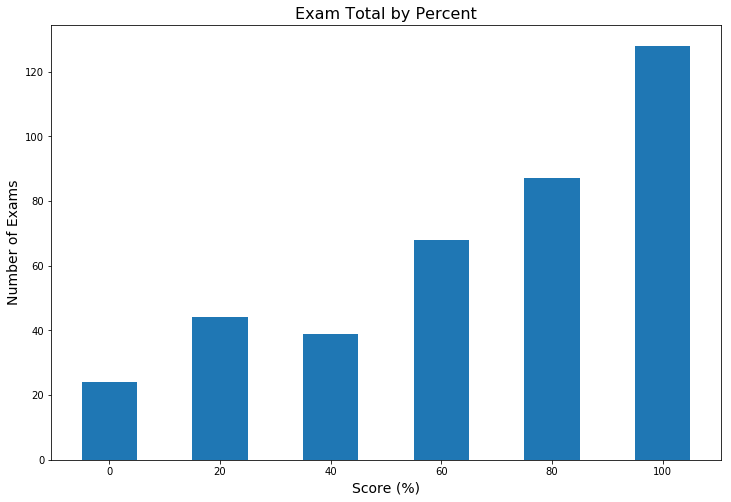

In [82]:
plt.figure(figsize=(12,8))
plt.bar(pd_learn_git_score.index, pd_learn_git_score.attempt, width=10)
plt.title("Exam Total by Percent", fontsize=16)
plt.xlabel("Score (%)", fontsize=14)
plt.ylabel("Number of Exams", fontsize=14)
plt.show()

### 3.10 What are the correct percentages for each Learning Git question?

In [83]:
learning_git_questions = \
spark.sql("select exam_name, \
          round((q01_correct/394)*100,2) q01_percent, \
          round((q02_correct/394)*100,2) q02_percent, \
          round((q03_correct/394)*100,2) q03_percent, \
          round((q04_correct/394)*100,2) q04_percent, \
          round((q05_correct/394)*100,2) q05_percent \
          from (select exam_name, \
                    sum(case when sequences.questions.user_correct[0] = 'true' then 1 else 0 end) as q01_correct, \
                    sum(case when sequences.questions.user_correct[1] = 'true' then 1 else 0 end) as q02_correct, \
                    sum(case when sequences.questions.user_correct[2] = 'true' then 1 else 0 end) as q03_correct, \
                    sum(case when sequences.questions.user_correct[3] = 'true' then 1 else 0 end) as q04_correct, \
                    sum(case when sequences.questions.user_correct[4] = 'true' then 1 else 0 end) as q05_correct \
                    from assessments \
                    group by exam_name) \
            where exam_name = 'Learning Git'")
learning_git_questions.show()

+------------+-----------+-----------+-----------+-----------+-----------+
|   exam_name|q01_percent|q02_percent|q03_percent|q04_percent|q05_percent|
+------------+-----------+-----------+-----------+-----------+-----------+
|Learning Git|      67.51|      67.51|      65.23|       66.5|      66.75|
+------------+-----------+-----------+-----------+-----------+-----------+



# 4.0 HDFS

### Pipeline

Now that the files have been transformed into a suitable format, they will be written to HDFS.  The pipeline location is transitioning from the streaming context to the distributed storage.

### Write to HDFS

In [84]:
extracted_assessments.write.parquet("/tmp/assessments")

In [85]:
git_scores.write.parquet("/tmp/git_scores")

### Read from HDFS

In [86]:
assessments_read = spark.read.parquet("/tmp/assessments")

In [87]:
git_scores_read = spark.read.parquet("/tmp/git_scores")

### Display pyspark sql dataframes

In [88]:
assessments_read.show(1)

+--------------------+-------------+--------------------+-----------------+--------------------+-----------------+------------+--------------------+--------------------+--------------------+
|        base_exam_id|certification|           exam_name|  keen_created_at|             keen_id|   keen_timestamp|max_attempts|           sequences|          started_at|        user_exam_id|
+--------------------+-------------+--------------------+-----------------+--------------------+-----------------+------------+--------------------+--------------------+--------------------+
|417d1748-76ab-11e...|        false|Learning Apache H...|1511377011.421613|5a15c873a4754b000...|1511377011.421613|         1.0|[1,[true,4,0,0,4,...|2017-11-22T18:55:...|27ccf268-a469-41a...|
+--------------------+-------------+--------------------+-----------------+--------------------+-----------------+------------+--------------------+--------------------+--------------------+
only showing top 1 row



In [89]:
git_scores_read.show()

+------------+--------------------+-------+----------+----------+---------+---------+-------+-----+-----+
|   exam_name|        user_exam_id|attempt|unanswered|incomplete|incorrect|submitted|correct|total|score|
+------------+--------------------+-------+----------+----------+---------+---------+-------+-----+-----+
|Learning Git|9d83503e-1e81-4c5...|      1|         0|         0|        0|        5|      5|    5|100.0|
|Learning Git|690ff7aa-6aca-47c...|      1|         0|         0|        2|        5|      3|    5| 60.0|
|Learning Git|1823d4f8-57a8-458...|      1|         0|         0|        0|        5|      5|    5|100.0|
|Learning Git|06616dd0-fff9-470...|      1|         0|         0|        5|        5|      0|    5|  0.0|
|Learning Git|e3ab5dd9-9810-4eb...|      1|         0|         0|        0|        5|      5|    5|100.0|
|Learning Git|ec8982ef-7747-4f8...|      1|         0|         0|        1|        5|      4|    5| 80.0|
|Learning Git|b3bbfe86-5163-459...|      1|   